In [1]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

In [2]:
def absolute_path_joiner(img_path: str):
    new_path = os.path.join(os.getcwd(), img_path)
    return new_path

## Load Image

In [3]:
os.listdir(".")

['.DS_Store', 'crop_utils.py', 'cv2_algo.ipynb', 'exp_imgs', '__pycache__']

In [4]:
SAMPLE_IMAGE_DIR = "../../../resources/need_annotating/OLOMBENDO/"
random.seed(42)
sample_images = random.choices(os.listdir(SAMPLE_IMAGE_DIR), k=10)
sample_image_paths = [os.path.join(SAMPLE_IMAGE_DIR, img) for img in sample_images]
sample_image_paths = [absolute_path_joiner(img) for img in sample_image_paths]
flags = []
imgs = [cv.imread(img_path) for img_path in sample_image_paths]
#img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_cmap = plt.get_cmap("gray")

## Detect Boundary Candidates and Crop

In [5]:
import cv2
from crop_utils import find_boundary_lines, get_figure_and_table_boundaries, extract_regions, translate_ocr_coordinates

In [36]:
img_no = 6

boundary_info = find_boundary_lines(
    imgs[img_no],
    canny_thresh1=50,
    canny_thresh2=200,
    hough_thresh=100,
    min_line_length=100,
    max_line_gap=20,
    angle_tolerance=5,
)

img_h, img_w, vert_lines, horz_lines = boundary_info
boundaries = get_figure_and_table_boundaries(
    img_h,
    img_w,
    vert_lines,
    horz_lines,
    border_margin_ratio=0.049,
    max_crawl_ratio=0.07,
    divider_search_ratio_start=0.776,
    edge_buffer_px=80,
)

figure_crop, table_crop, figure_offset, table_offset = extract_regions(imgs[img_no], boundaries, padding=10)

Detected 518 potential vertical lines.
Detected 1745 potential horizontal lines.
Edge buffers set to: x=80px, y=80px
Calculated Boundaries (Robust, Buffered): {'y_top': 114, 'y_bottom': 3229, 'x_left': 115, 'x_right': 4567, 'x_divider': 3839}
Figure extracted: shape=(3095, 3704, 3) at offset (125, 124)
Table extracted: shape=(3095, 708, 3) at offset (3849, 124)


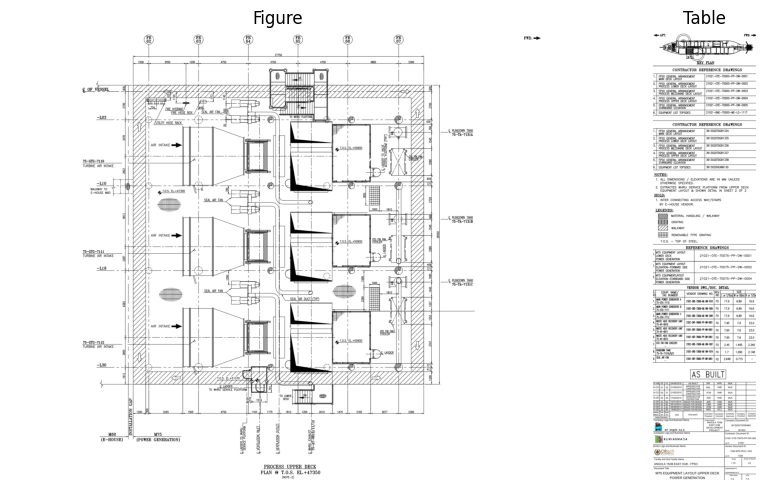

In [37]:
if figure_crop is not None and table_crop is not None:
    # --- Resizing ---
    display_scale = 0.4
    figure_display = None
    table_display = None

    if figure_crop.shape[1] > 0 and figure_crop.shape[0] > 0:
        figure_display = cv2.resize(
            figure_crop,
            (
                int(figure_crop.shape[1] * display_scale),
                int(figure_crop.shape[0] * display_scale),
            ),
            interpolation=cv2.INTER_AREA,  # Specify interpolation for resizing
        )
    else:
        print("Warning: Figure crop resulted in zero dimension.")

    if table_crop.shape[1] > 0 and table_crop.shape[0] > 0:
        table_display = cv2.resize(
            table_crop,
            (
                int(table_crop.shape[1] * display_scale),
                int(table_crop.shape[0] * display_scale),
            ),
            interpolation=cv2.INTER_AREA,  # Specify interpolation for resizing
        )
    else:
        print("Warning: Table crop resulted in zero dimension.")

    # --- Displaying Side-by-Side ---
    # Check if both resized images are valid before trying to plot
    if figure_display is not None and table_display is not None:
        # Create a figure and a set of subplots
        # plt.subplots(nrows, ncols, figsize=(width, height))
        # For side-by-side, we want 1 row, 2 columns
        fig, axes = plt.subplots(
            1, 2, figsize=(10, 5)
        )  # Adjust figsize as needed

        # axes is an array of Axes objects. axes[0] is the first subplot, axes[1] is the second.

        # Display the first image on the left subplot (axes[0])
        axes[0].imshow(figure_display)
        axes[0].set_title("Figure")
        axes[0].axis("off")  # Hide axes ticks and labels

        # Display the second image on the right subplot (axes[1])
        # Use the grayscale colormap defined earlier
        axes[1].imshow(table_display, cmap=gray_cmap)
        axes[1].set_title("Table")
        axes[1].axis("off")  # Hide axes ticks and labels

        # Adjust layout to prevent titles/images from overlapping
        plt.tight_layout()

        # Show the figure window with both subplots
        plt.show()

Image 6 of 10 with shape (3392, 4768, 3)


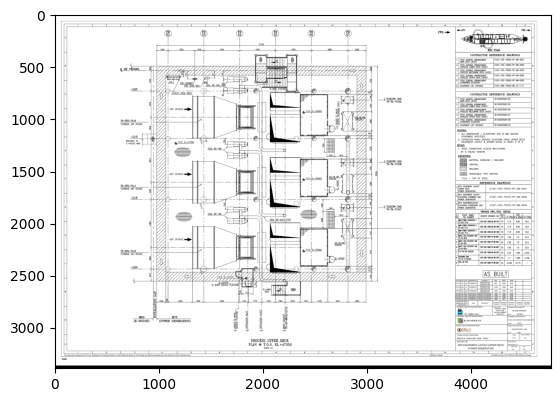

In [33]:
print(f"Image {img_no} of {len(imgs)} with shape {imgs[img_no].shape}")
plt.imshow(imgs[img_no][:,:])

In [9]:
np.unique(imgs[img_no][-30:,:])

array([  0,  18,  20,  56,  75,  99, 108, 110, 127, 137, 148, 156, 174,
       176, 177, 179, 181, 193, 195, 197, 201, 210, 218, 219, 223, 236,
       238, 247, 250, 253, 255], dtype=uint8)

## Translate OCR Results From Crop -> Original Image Coordinate System

In [10]:
figure_ocr = [
    {"text": "VE-30-10", "bbox": [50, 100, 80, 20], "confidence": 0.99},
]

table_ocr = [
    {"text": "Contractor:", "bbox": [50, 200, 80, 20], "confidence": 0.99},
]

ocr_absolutes = translate_ocr_coordinates(figure_ocr, table_ocr, figure_offset, table_offset)

Translated coordinates for 2 OCR results.


In [11]:
ocr_absolutes

[{'text': 'VE-30-10',
  'bbox': [167, 239, 80, 20],
  'confidence': 0.99,
  'source_crop': 'figure'},
 {'text': 'Contractor:',
  'bbox': [3745, 339, 80, 20],
  'confidence': 0.99,
  'source_crop': 'table'}]